In [1]:
from dotenv import load_dotenv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
dataset_path = os.getenv("DATASET_PATH")

if not dataset_path:
    raise ValueError("DATASET_PATH NOT FOUND")

print("Files available in dataset:")
data_file = None
for filename in os.listdir(dataset_path):
    print(filename)
    if filename.endswith(".csv"):
        data_file = os.path.join(dataset_path, filename)

if not data_file:
    raise ValueError("No CSV file found in dataset folder")


pd.set_option("display.float_format", "{:.0f}".format)

df = pd.read_csv(data_file)

print("=== Raw data info ===")
df.info()

print("\n=== Raw numeric summary ===")
print(df.describe())

print("\n=== First 5 raw rows ===")
print(df.head())


df["TRANSACTION_DT"] = pd.to_datetime(
    df["TRANSACTION_DT"],
    format="%m/%d/%Y",
    errors="coerce"
)

df.describe()


Files available in dataset:
uapriori_dataset.csv
ta_feng_all_months_merged.csv
=== Raw data info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817741 entries, 0 to 817740
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   TRANSACTION_DT    817741 non-null  object
 1   CUSTOMER_ID       817741 non-null  int64 
 2   AGE_GROUP         795379 non-null  object
 3   PIN_CODE          817741 non-null  object
 4   PRODUCT_SUBCLASS  817741 non-null  int64 
 5   PRODUCT_ID        817741 non-null  int64 
 6   AMOUNT            817741 non-null  int64 
 7   ASSET             817741 non-null  int64 
 8   SALES_PRICE       817741 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 56.1+ MB

=== Raw numeric summary ===
       CUSTOMER_ID  PRODUCT_SUBCLASS    PRODUCT_ID  AMOUNT  ASSET  SALES_PRICE
count       817741            817741        817741  817741 817741       817741
mean       1406620            2849

,TRANSACTION_DT,CUSTOMER_ID,PRODUCT_SUBCLASS,PRODUCT_ID,AMOUNT,ASSET,SALES_PRICE
count,817741,817741,817741,817741,817741,817741,817741
mean,2000-12-30 16:40:45.147790848,1406620,284950,4461639280529,1,112,132
min,2000-11-01 00:00:00,1069,100101,20008819,1,0,1
25%,2000-11-28 00:00:00,969222,110106,4710085127016,1,35,42
50%,2001-01-01 00:00:00,1587722,130106,4710421090059,1,62,76
75%,2001-01-30 00:00:00,1854930,520314,4712500125126,1,112,132
max,2001-02-28 00:00:00,20002000,780510,9789579967617,1200,432000,444000
std,NaN,748978,226391,1690093349432,3,604,631


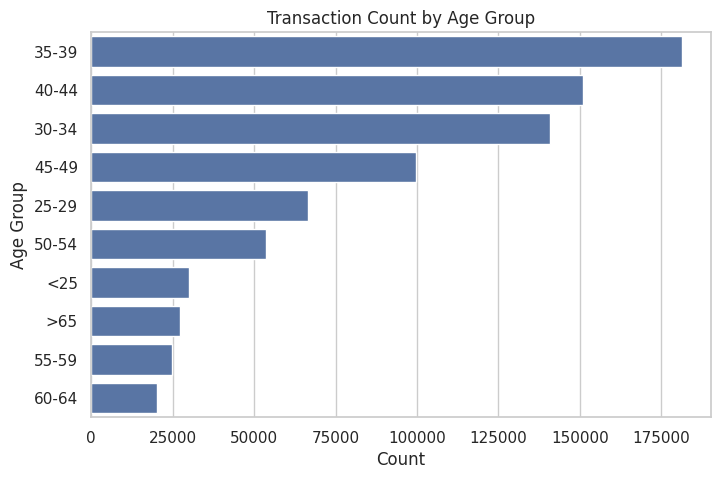

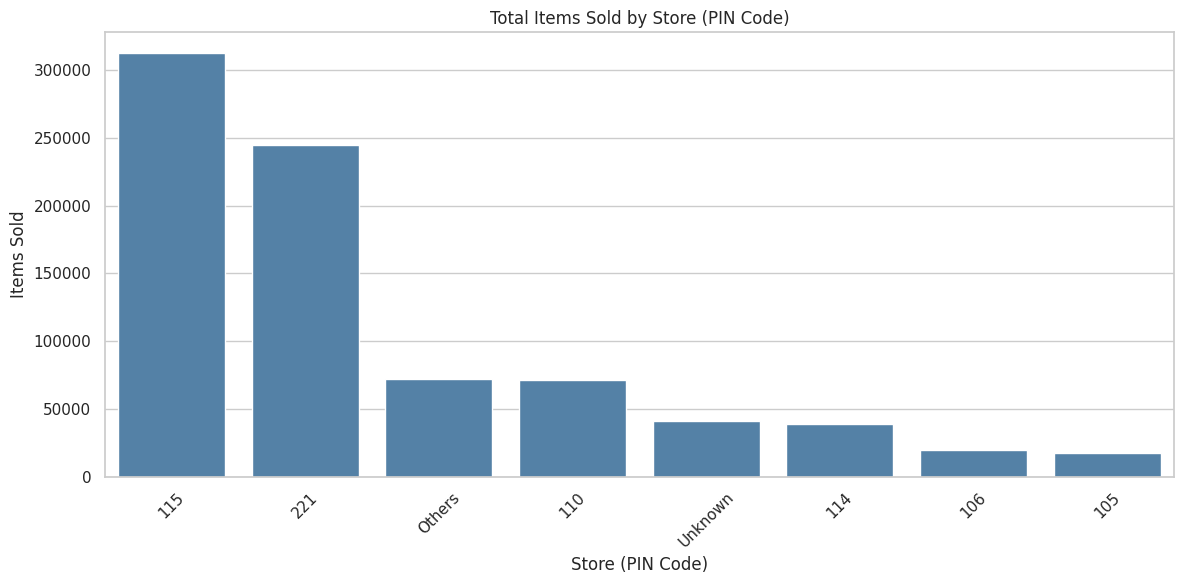

Top store (PIN): 115 sold 312501 items.
  PIN_CODE  TOTAL_ITEMS_SOLD  PERCENT
4      115            312501       38
5      221            245213       30


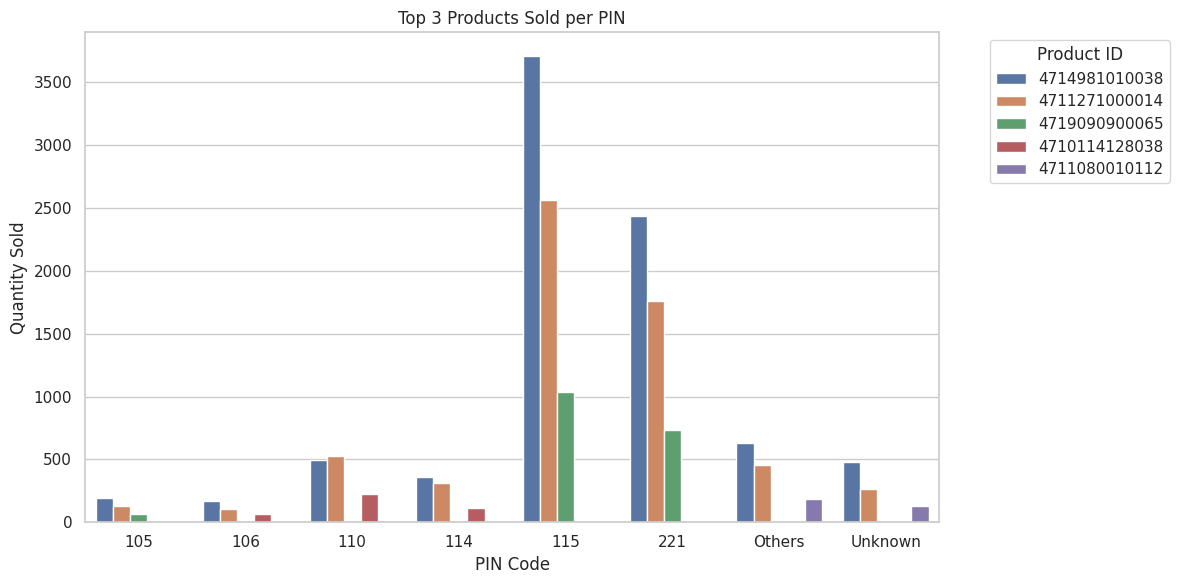

      PIN_CODE     PRODUCT_ID  QUANTITY
5242       105  4714981010038       192
3918       105  4711271000014       127
5743       105  4719090900065        69
12443      106  4714981010038       167
10975      106  4711271000014       109
9020       106  4710114128038        68
21148      110  4711271000014       530
24053      110  4714981010038       498
17931      110  4710114128038       222
35031      114  4714981010038       357
32909      114  4711271000014       311
30293      114  4710114128038       110
51885      115  4714981010038      3713
47357      115  4711271000014      2562
53943      115  4719090900065      1037
71442      221  4714981010038      2439
67042      221  4711271000014      1761
73398      221  4719090900065       732
87037   Others  4714981010038       627
83955   Others  4711271000014       455
83707   Others  4711080010112       185
98516  Unknown  4714981010038       483
96401  Unknown  4711271000014       265
96189  Unknown  4711080010112       129


In [2]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.countplot(y="AGE_GROUP", data=df, order=df["AGE_GROUP"].value_counts().index)
plt.title("Transaction Count by Age Group")
plt.xlabel("Count")
plt.ylabel("Age Group")
plt.show()

pin_sales = (
    df.groupby("PIN_CODE")["PRODUCT_ID"]
    .count()
    .reset_index(name="TOTAL_ITEMS_SOLD")
    .sort_values("TOTAL_ITEMS_SOLD", ascending=False)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=pin_sales,
    x="PIN_CODE",
    y="TOTAL_ITEMS_SOLD",
    color="steelblue"
)
plt.title("Total Items Sold by Store (PIN Code)")
plt.xlabel("Store (PIN Code)")
plt.ylabel("Items Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top_store = pin_sales.iloc[0]
print(f"Top store (PIN): {top_store['PIN_CODE']} sold {top_store['TOTAL_ITEMS_SOLD']} items.")

total_items = pin_sales["TOTAL_ITEMS_SOLD"].sum()

subset = pin_sales[pin_sales["PIN_CODE"].isin(["115", "221"])].copy()

subset["PERCENT"] = (subset["TOTAL_ITEMS_SOLD"] / total_items) * 100

print(subset[["PIN_CODE", "TOTAL_ITEMS_SOLD", "PERCENT"]])

product_pin_qty = (
    df.groupby(["PIN_CODE", "PRODUCT_ID"])
      .size()
      .reset_index(name="QUANTITY")
)

top3_per_pin = (
    product_pin_qty
    .sort_values(["PIN_CODE", "QUANTITY"], ascending=[True, False])
    .groupby("PIN_CODE")
    .head(3)
)

top3_per_pin["PRODUCT_ID"] = top3_per_pin["PRODUCT_ID"].astype(str)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top3_per_pin,
    x="PIN_CODE",
    y="QUANTITY",
    hue="PRODUCT_ID"
)
plt.title("Top 3 Products Sold per PIN")
plt.xlabel("PIN Code")
plt.ylabel("Quantity Sold")
plt.legend(title="Product ID", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

print(top3_per_pin.sort_values(["PIN_CODE", "QUANTITY"], ascending=[True, False]))




In [3]:
#preprocessing

print("\n=== Missing values before filtering ===")
print(df.isnull().sum())

mask = (
    (df["PIN_CODE"].notna()) &
    (~df["PIN_CODE"].isin(["Others", "Unknown"])) &
    (df["AGE_GROUP"].notna())
)
df = df.loc[mask].copy()
df.reset_index(drop=True, inplace=True)


df = df[mask].copy()
df.reset_index(drop=True, inplace=True)

print("\n=== Missing values after filtering ===")
print(df.isnull().sum())

print("\n=== Cleaned data info ===")
df.info()

print("\n=== First 5 cleaned rows ===")
print(df.head())

print("\n=== AGE_GROUP distribution ===")
print(df["AGE_GROUP"].value_counts())

print("\n=== Top 10 PIN_CODE values ===")
print(df["PIN_CODE"].value_counts().head(10))

print(df.info())
print(df.describe())
raw_df = df.copy()




=== Missing values before filtering ===
TRANSACTION_DT          0
CUSTOMER_ID             0
AGE_GROUP           22362
PIN_CODE                0
PRODUCT_SUBCLASS        0
PRODUCT_ID              0
AMOUNT                  0
ASSET                   0
SALES_PRICE             0
dtype: int64

=== Missing values after filtering ===
TRANSACTION_DT      0
CUSTOMER_ID         0
AGE_GROUP           0
PIN_CODE            0
PRODUCT_SUBCLASS    0
PRODUCT_ID          0
AMOUNT              0
ASSET               0
SALES_PRICE         0
dtype: int64

=== Cleaned data info ===


/tmp/ipykernel_7574/777644444.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[mask].copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599142 entries, 0 to 599141
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   TRANSACTION_DT    599142 non-null  datetime64[ns]
 1   CUSTOMER_ID       599142 non-null  int64         
 2   AGE_GROUP         599142 non-null  object        
 3   PIN_CODE          599142 non-null  object        
 4   PRODUCT_SUBCLASS  599142 non-null  int64         
 5   PRODUCT_ID        599142 non-null  int64         
 6   AMOUNT            599142 non-null  int64         
 7   ASSET             599142 non-null  int64         
 8   SALES_PRICE       599142 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 41.1+ MB

=== First 5 cleaned rows ===
  TRANSACTION_DT  CUSTOMER_ID AGE_GROUP PIN_CODE  PRODUCT_SUBCLASS  \
0     2000-11-01      1104905     45-49      115            110411   
1     2000-11-01       418683     45-49      

In [4]:
#make it u-apriori compatible
import numpy as np

df = raw_df.copy()  

df['TID'] = df.groupby(['CUSTOMER_ID', 'TRANSACTION_DT']).ngroup()

df = df.drop_duplicates(['TID', 'PRODUCT_ID'])

U = np.random.uniform(0.0, 1.0, size=len(df))
c = 1.0
df['PROB'] = 0.9 - 0.2 * (U ** c)

udb = df[['TID', 'PRODUCT_ID', 'PROB']].copy()

print("Transactions:", udb['TID'].nunique())
basket_sizes = udb.groupby('TID')['PRODUCT_ID'].nunique()
print("Rows:", len(udb))
print("Avg basket size:", float(basket_sizes.mean()))
print("Min basket size:", int(basket_sizes.min()))
print("Max basket size:", int(basket_sizes.max()))
print("Duplicate (TID, PRODUCT_ID):", int(udb.duplicated(['TID','PRODUCT_ID']).sum()))

print("\nPROB bounds:", float(udb['PROB'].min()), float(udb['PROB'].max()))
print(udb['PROB'].describe())


Transactions: 99283
Rows: 599142
Avg basket size: 6.03468871810884
Min basket size: 1
Max basket size: 94
Duplicate (TID, PRODUCT_ID): 0

PROB bounds: 0.7000000373575985 0.8999994686499628
count   599142
mean         1
std          0
min          1
25%          1
50%          1
75%          1
max          1
Name: PROB, dtype: float64


In [ ]:
import numpy as np
pd.reset_option('display.float_format')
# start from clean copy
df = raw_df.copy()

# 1. Transaction id: one basket = one (CUSTOMER_ID, TRANSACTION_DT)
df['TID'] = df.groupby(['CUSTOMER_ID', 'TRANSACTION_DT']).ngroup()

# 2. One row per (TID, PRODUCT_ID)
df = df.drop_duplicates(['TID', 'PRODUCT_ID'])

# 3. Existential probabilities: p = 0.9 - 0.2 * U^c in [0.7, 0.9]
U = np.random.uniform(0.0, 1.0, size=len(df))
c = 1.0
df['PROB'] = 0.9 - 0.2 * (U ** c)

# 4. Final U-Apriori table
udb = df[['TID', 'PRODUCT_ID', 'PROB']].copy()

# ===== CHECKS =====
print("HEAD:")
print(udb.head())

print("\nPROB describe():")
print(udb['PROB'].describe())

print("\nBounds:")
print("min:", udb['PROB'].min())
print("max:", udb['PROB'].max())

print("\nAny PROB == 1:", (udb['PROB'] == 1).any())
print("Any PROB < 0.7:", (udb['PROB'] < 0.7).any())
print("Any PROB > 0.9:", (udb['PROB'] > 0.9).any())

basket_sizes = udb.groupby('TID')['PRODUCT_ID'].nunique()
print("\nTransactions:", udb['TID'].nunique())
print("Rows:", len(udb))
print("Avg basket size:", basket_sizes.mean())
print("Min basket size:", basket_sizes.min())
print("Max basket size:", basket_sizes.max())
print("Duplicate (TID, PRODUCT_ID):", udb.duplicated(['TID','PRODUCT_ID']).sum())


HEAD:
     TID     PRODUCT_ID  PROB
0  31783  4710199010372     1
1  12038  4710857472535     1
2  30582  4710043654103     1
3  63914    78895770025     1
4   9594  4710192225520     1

PROB describe():
count   599142
mean         1
std          0
min          1
25%          1
50%          1
75%          1
max          1
Name: PROB, dtype: float64

Bounds:
min: 0.7000000245558529
max: 0.8999994554753291

Any PROB == 1: False
Any PROB < 0.7: False
Any PROB > 0.9: False

Transactions: 99283
Rows: 599142
Avg basket size: 6.03468871810884
Min basket size: 1
Max basket size: 94
Duplicate (TID, PRODUCT_ID): 0
